In [7]:
import sys
import os
os.environ["STATS_PBAR"] = "1"
from pathlib import Path
sys.path.append(Path.cwd().parent.__str__())
from pprint import pprint
import random
from dronescapes_reader import MultiTaskDataset
from dronescapes_reader.dronescapes_representations import dronescapes_task_types, semantic_mapper, TaskMapper, \
    mapillary_classes, coco_classes
import numpy as np
import torch as tr
from torch.nn import functional as F
from media_processing_lib.collage_maker import collage_fn
from media_processing_lib.image import image_add_title, image_write
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
reader = MultiTaskDataset("../data/train_set", task_names=list(dronescapes_task_types.keys()),
                          task_types=dronescapes_task_types, handle_missing_data="fill_nan",
                          normalization="min_max", cache_task_stats=True, batch_size_stats=100)
print(reader)
print("== Shapes ==")
pprint(reader.data_shape)

[2024-10-19T16:11:31 INFO] Total files: 3 per task across 3 tasks (multitask_dataset.py:_build_dataset:246)
[2024-10-19T16:11:31 INFO] Tasks used in this dataset: ['depth_marigold', 'rgb', 'semantic_mask2former_swin_mapillary_converted'] (multitask_dataset.py:__init__:83)
[2024-10-19T16:11:31 INFO] Normalization provided as a string (min_max). Setting all tasks to this (multitask_dataset.py:__init__:87)
[2024-10-19T16:11:31 INFO] Loaded task statistics: {'depth_dpt': (1,), 'rgb': (3,), 'semantic_mask2former_swin_mapillary_converted': (8,), 'depth_marigold': (1,)} from /home/mihai/code/ml/neo-transformers/ci/data/dronescapes/train/.task_statistics.npz (multitask_dataset.py:_compute_statistics:264)


[MultiTaskDataset]
 - Path: '/home/mihai/code/ml/neo-transformers/ci/data/dronescapes/train'
 - Tasks (3): [DepthRepresentation(depth_marigold[1]), RGBRepresentation(rgb[3]), SemanticMask2FormerMapillaryConvertedPaper(semantic_mask2former_swin_mapillary_converted[8])]
 - Length: 3
 - Handle missing data mode: 'fill_nan'
 - Normalization: '{'depth_marigold': 'min_max', 'rgb': 'min_max', 'semantic_mask2former_swin_mapillary_converted': 'min_max'}'
== Shapes ==
{'depth_marigold': (540, 960, 1),
 'rgb': (540, 960, 3),
 'semantic_mask2former_swin_mapillary_converted': (540, 960, 8)}


In [9]:

class BuildingsFromM2F2(TaskMapper):
    def __init__(self, original_classes: tuple[list[str], list[str]]):
        mapping = [
            {
                "man-made-construction": ["Building"],
                "others": [x for x in original_classes[0] if x != "Building"]
            },
            {
                "man-made-construction": ["building-other-merged", "house", "roof"],
                "others": [x for x in original_classes[1] if x not in ["building-other-merged", "house", "roof"]]
            }
        ]
        dependencies = [dronescapes_task_types["semantic_mask2former_mapillary_49189528_0"],
                        dronescapes_task_types["semantic_mask2former_coco_47429163_0"]]
        super().__init__("semantic_buildings_m2f2", dependencies=dependencies, merge_fn=self._merge_fn, n_channels=2)
        self.color_map = [[255, 255, 255], [0, 0, 0]]
        self.original_classes = original_classes
        self.mapping = mapping
        self.classes = list(mapping[0].keys())
        self.n_classes = len(self.classes)

    def plot_fn(self, x: tr.Tensor) -> np.ndarray:
        x_argmax = x.squeeze().nan_to_num(0).detach().argmax(-1).cpu().numpy()
        new_images = np.zeros((*x_argmax.shape, 3), dtype=np.uint8)
        for i in range(self.n_classes):
            new_images[x_argmax == i] = self.color_map[i]
        return new_images

    def _merge_fn(self, dep_data: list[np.ndarray]) -> tr.Tensor:
        m2f_mapillary, m2f_coco = dep_data[0].argmax(-1).numpy(), dep_data[1].argmax(-1).numpy()
        m2f_mapillary_converted = semantic_mapper(m2f_mapillary, self.mapping[0], self.original_classes[0])
        m2f_coco_converted = semantic_mapper(m2f_coco, self.mapping[1], self.original_classes[1])
        combined = (m2f_mapillary_converted + m2f_coco_converted) != 0
        combined_oh = F.one_hot(tr.from_numpy(combined).long(), num_classes=self.n_classes).float()
        return combined_oh

if "semantic_buildings_m2f" in reader.task_names:
    reader.remove_task("semantic_buildings_m2f")
reader.add_task(BuildingsFromM2F2([mapillary_classes, coco_classes]))


[2024-10-19T16:11:32 INFO] Total files: 3 per task across 4 tasks (multitask_dataset.py:_build_dataset:246)


== Random loaded item ==
barsana_DJI_0500_0501_combined_sliced_2700_14700_10680.npz


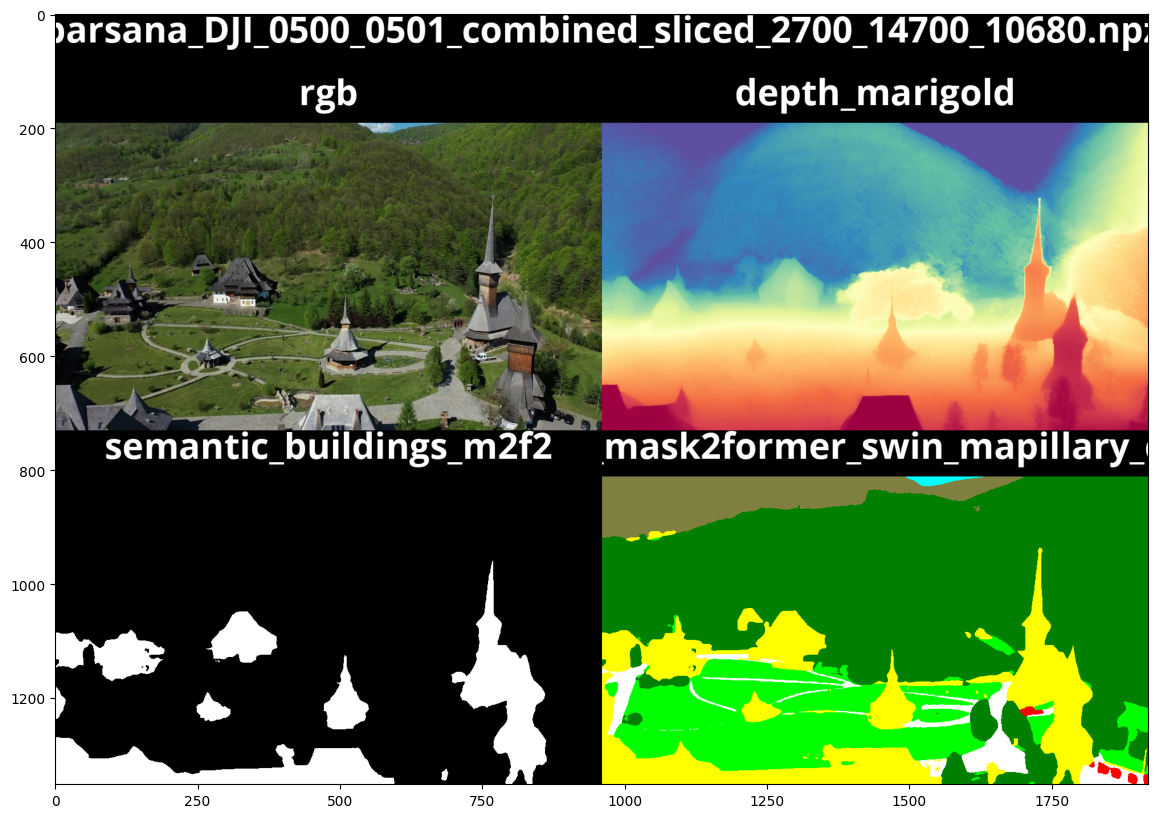

In [10]:
print("== Random loaded item ==")
rand_ix = random.randint(0, len(reader) - 1)
data, name, repr_names = reader[rand_ix] # get a random item
print(name)
img_data = {}
for k, v in data.items():
    img_data[k] = reader.name_to_task[k].plot_fn(v) if v is not None else np.zeros((*reader.data_shape[k][0:2], 3))
if "rgb" in img_data: # move rgb as 1st item in the collage
    img_data = {"rgb": img_data["rgb"], **{k: v for k, v in img_data.items() if k != "rgb"}}
# pprint({k: v.shape for k, v in img_data.items()})
collage = collage_fn(list(img_data.values()), titles=img_data.keys(), size_px=55)
collage = image_add_title(collage, name, size_px=55, top_padding=110)
plt.figure(figsize=(20, 10))
plt.imshow(collage)
image_write(collage, f"collage_{name}.png")